## Imports

In [1]:
!pip install -U albumentations>=3.0.0
!git clone https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models

Cloning into 'TensorFlow-Advanced-Segmentation-Models'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 512 (delta 153), reused 73 (delta 39), pack-reused 276
Receiving objects: 100% (512/512), 1021.33 KiB | 1.37 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [2]:
%cd TensorFlow-Advanced-Segmentation-Models
import tensorflow_advanced_segmentation_models as tasm
%cd ..

/content/TensorFlow-Advanced-Segmentation-Models
/content


In [3]:
import os
import cv2
import numpy as np
from time import time
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

## Directories

In [4]:
# Data Handling

DATA_DIR = "drive/My Drive/dataset1"

x_train_dir = os.path.join(DATA_DIR, 'parent_train_img/train_img')
y_train_dir = os.path.join(DATA_DIR, 'parent_train_annot/train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'parent_val_img/val_img')
y_valid_dir = os.path.join(DATA_DIR, 'parent_val_annot/val_annot')

x_test_dir = os.path.join(DATA_DIR, 'parent_test_img/test_img')
y_test_dir = os.path.join(DATA_DIR, 'parent_test_annot/test_annot')


### Helper Functions

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

## Data Augmentation Functions

In [6]:
# define heavy augmentations
def get_training_augmentation(height, width):
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.6, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0),
        A.RandomCrop(height=height, width=width, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(height, width):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(height, width),
        A.Resize(height, width, always_apply=True)
    ]
    return A.Compose(test_transform)

def data_get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

## Define some global variables

In [7]:
TOTAL_CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
N_TOTAL_CLASSES = 12
# CLASSES_DICT = {"sky": 0, "building": 1, "pole": 2, "road": 3, "pavement": 4,
#                 "tree": 5, "signsymbol": 6, "fence": 7, "car": 8,
#                 "pedestrian": 9, "bicyclist": 10, "unlabelled": 11}
# Dervied from Matlab: https://it.mathworks.com/help/vision/examples/semantic-segmentation-using-deep-learning.html
CLASSES_PIXEL_COUNT_DICT = {"sky": 76801000, "building": 117370000,
                            "pole": 4799000, "road": 140540000,
                            "pavement": 33614000, "tree": 54259000,
                            "signsymbol": 5224000, "fence": 69211000,
                            "car": 2437000, "pedestrian": 3403000,
                            "bicyclist": 2591000, "unlabelled": 0}

MODEL_CLASSES = ["sky", "building"]
BATCH_SIZE = 4
N_CLASSES = 3
HEIGHT = 320
WIDTH = 320
BACKBONE_NAME = "efficientnetb3"
WEIGHTS = "imagenet"
WWO_AUG = True # train data with and without augmentation

### Functions to calculate appropriate class weights

In [8]:
################################################################################
# Class Weights
################################################################################
def get_dataset_counts(d):
    pixel_count = np.array([i for i in d.values()])

    sum_pixel_count = 0
    for i in pixel_count:
        sum_pixel_count += i

    return pixel_count, sum_pixel_count

def get_dataset_statistics(pixel_count, sum_pixel_count):
    
    pixel_frequency = np.round(pixel_count / sum_pixel_count, 4)

    mean_pixel_frequency = np.round(np.mean(pixel_frequency), 4)

    return pixel_frequency, mean_pixel_frequency

def get_balancing_class_weights(classes, d):
    pixel_count, sum_pixel_count = get_dataset_counts(d)

    background_pixel_count = 0
    mod_pixel_count = []
    for c in TOTAL_CLASSES:
        if c not in classes:
            background_pixel_count += d[c]
        else:
            mod_pixel_count.append(d[c])
    mod_pixel_count.append(background_pixel_count)
    
    pixel_frequency, mean_pixel_frequency = get_dataset_statistics(mod_pixel_count, sum_pixel_count)

    class_weights = np.round(mean_pixel_frequency / pixel_frequency, 2)
    return class_weights    

class_weights = get_balancing_class_weights(MODEL_CLASSES, CLASSES_PIXEL_COUNT_DICT)
print(class_weights)

[2.21 1.45 0.54]


## Data Generation Functions

In [9]:
################################################################################
# Data Generator
################################################################################
def create_image_label_path_generator(images_dir, masks_dir, shuffle=False, seed=None):
    ids = sorted(os.listdir(images_dir))
    mask_ids = sorted(os.listdir(masks_dir))

    if shuffle == True:

        if seed is not None:
            tf.random.set_seed(seed)

        indices = tf.range(start=0, limit=tf.shape(ids)[0], dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)

        ids = tf.gather(ids, shuffled_indices).numpy().astype(str)
        mask_ids = tf.gather(mask_ids, shuffled_indices).numpy().astype(str)

    images_fps = [os.path.join(images_dir, image_id) for image_id in ids]
    masks_fps = [os.path.join(masks_dir, image_id) for image_id in mask_ids]

    while True:
        for i in range(len(images_fps)):
            yield [images_fps[i], masks_fps[i]]


def process_image_label(images_paths, masks_paths, classes, augmentation=None, preprocessing=None):
    class_values = [TOTAL_CLASSES.index(cls.lower()) for cls in classes]
    
    # read data
    image = cv2.imread(images_paths)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks_paths, 0)

    # extract certain classes from mask (e.g. cars)
    masks = [(mask == v) for v in class_values]
    mask = np.stack(masks, axis=-1).astype('float')
    
    # add background if mask is not binary
    if mask.shape[-1] != 1:
        background = 1 - mask.sum(axis=-1, keepdims=True)
        mask = np.concatenate((mask, background), axis=-1)
    
    # apply augmentations
    if augmentation:
        sample = augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if preprocessing:
        sample = preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    # mask = np.squeeze(np.argmax(mask, axis=-1))
    # mask = np.argmax(mask, axis=-1)
    # mask = mask[..., np.newaxis]
        
    return image, mask

def DataGenerator(train_dir, label_dir, batch_size, height, width, classes, augmentation, wwo_aug=False, shuffle=False, seed=None):
    image_label_path_generator = create_image_label_path_generator(
        train_dir, label_dir, shuffle=shuffle, seed=seed
    )
    if wwo_aug:
        while True:
            images = np.zeros(shape=[batch_size, height, width, 3])
            labels = np.zeros(shape=[batch_size, height, width, len(classes) + 1], dtype=np.float32)
            for i in range(0, batch_size, 2):
                image_path, label_path = next(image_label_path_generator)
                image_aug, label_aug = process_image_label(image_path, label_path, classes=classes, augmentation=augmentation)
                image_wo_aug, label_wo_aug = process_image_label(image_path, label_path, classes=classes, augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH))
                images[i], labels[i] = image_aug, label_aug
                images[i + 1], labels[i + 1] = image_wo_aug, label_wo_aug

            yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)
    else:
        while True:
            images = np.zeros(shape=[batch_size, height, width, 3])
            labels = np.zeros(shape=[batch_size, height, width, len(classes) + 1], dtype=np.float32)
            for i in range(batch_size):
                image_path, label_path = next(image_label_path_generator)
                image, label = process_image_label(image_path, label_path, classes=classes, augmentation=augmentation)
                images[i], labels[i] = image, label

            yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)

## Create the Model

In [10]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = False
model = tasm.DANet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

43941888/43941136 [==============================] - 1s 0us/step


### Define the optimizer as well as losses, metrics and callbacks

In [11]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
            #  tf.keras.callbacks.ModelCheckpoint("DeepLabV3plus.ckpt", verbose=1, save_weights_only=True, save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

### Get the Data

<p>There are three options for the training dataset: </p>

- Training without augmentation
- Training with augmentation
- Training with and without augmentation (twice the data)

<p>Validation and Test data are of course without augmentation</p>

In [12]:
train_shuffle = True
val_shuffle = True
seed = 29598

TrainSet = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH),
    shuffle=train_shuffle,
    seed=seed
    )

TrainSetwoAug = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
    shuffle=train_shuffle,
    seed=seed
)

TrainSetwwoAug = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH),
    wwo_aug=True,
    shuffle=train_shuffle,
    seed=seed
)

ValidationSet = DataGenerator(
    x_valid_dir,
    y_valid_dir,
    1,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
    shuffle=val_shuffle,
    seed=seed
)

TestSet = DataGenerator(
    x_test_dir,
    y_test_dir,
    1,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
)

for i in TrainSet:
    sample_image, sample_mask = i[0][0], i[1][0]
    print(len(i))
    print(i[0].shape)
    print(i[1].shape)
    break

print(len(os.listdir(x_train_dir)))
print(len(os.listdir(x_valid_dir)))
print(len(os.listdir(x_test_dir)))

2
(4, 320, 320, 3)
(4, 320, 320, 3)
307
60
101


<p>Short check if model works properly.</p>


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

SparseCategoricalCrossentroy: 1.23156
Iou-Score: 0.20431411
categorical Focal Dice Loss: 0.71970665


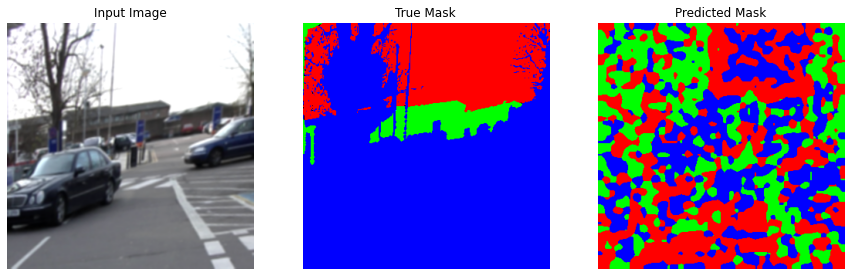

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    
    output_model = model(sample_image[tf.newaxis, ...])
    # print(output_model.numpy())
    
    output_mask = create_mask(output_model)
    # print(sample_mask.shape)

    scce = tf.keras.losses.CategoricalCrossentropy()
    print("SparseCategoricalCrossentroy: " + str(scce(sample_mask, output_model[0]).numpy()))
    print("Iou-Score: " + str(tasm.losses.iou_score(sample_mask, output_model[0]).numpy()))
    print("categorical Focal Dice Loss: " + str(categorical_focal_dice_loss(sample_mask, output_model[0]).numpy()))
    
    display([sample_image, sample_mask, K.one_hot(K.squeeze(output_mask, axis=-1), 3)])
    
show_predictions()

In [14]:
### try training with a shuffled generator 
### reimplement datagenerator
### idea: first generate img-/label-tensors
###       second take list of img-/label-tensors and shuffle them
###       third write generator that yields shuffled list ( or give it to fit without generator approach )

# Compare training procedures with and without shuffling and with and without class weights (especially in loss)

# Training

## Training Procedure

##### 1) Train model with freezed backbone only on train data
##### 2) Train model last backbone block unfreezed and rest freezed only on train data
##### 3) Train completly unfreezed model with train data
##### 4) Train completly unfreezed model with train and validation data

### 1) Train model with freezed backbone only on train data

<p>Set Backbone trainable to False.</p>

In [15]:
for layer in model.layers:
    if "functional" in layer.name:
        layer.trainable = False

    print(layer.name + ": " + str(layer.trainable))

up_sampling2d: True
functional_1: False
convolution_bn_activation: True
convolution_bn_activation_1: True
pam__module: True
cam__module: True
convolution_bn_activation_5: True
convolution_bn_activation_6: True
dropout: True
dropout_1: True
dropout_2: True
convolution_bn_activation_7: True
convolution_bn_activation_8: True
convolution_bn_activation_9: True
concatenate_1: True
concatenate_2: True
convolution_bn_activation_10: True


In [16]:
if WWO_AUG:
    steps_per_epoch = np.floor(len(os.listdir(x_train_dir)) / BATCH_SIZE) * 2
else:
    steps_per_epoch = np.floor(len(os.listdir(x_train_dir)) / BATCH_SIZE)

history = model.fit(
    TrainSetwwoAug,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    callbacks=callbacks,
    )

Epoch 1/100
152/152 [==============================] - 625s 4s/step - loss: 0.3164 - iou_score: 0.6417
Epoch 2/100
152/152 [==============================] - 63s 416ms/step - loss: 0.2478 - iou_score: 0.7049
Epoch 3/100
152/152 [==============================] - 61s 403ms/step - loss: 0.2260 - iou_score: 0.7258
Epoch 4/100
152/152 [==============================] - 62s 405ms/step - loss: 0.2262 - iou_score: 0.7268
Epoch 5/100
152/152 [==============================] - 61s 403ms/step - loss: 0.2232 - iou_score: 0.7290
Epoch 6/100
152/152 [==============================] - 62s 405ms/step - loss: 0.2120 - iou_score: 0.7417
Epoch 7/100
152/152 [==============================] - 62s 405ms/step - loss: 0.2007 - iou_score: 0.7547
Epoch 8/100
152/152 [==============================] - 62s 406ms/step - loss: 0.2046 - iou_score: 0.7502
Epoch 9/100
152/152 [==============================] - 62s 408ms/step - loss: 0.1986 - iou_score: 0.7563
Epoch 10/100
152/152 [==============================] - 6

### Plot Training IoU Scores and Losses

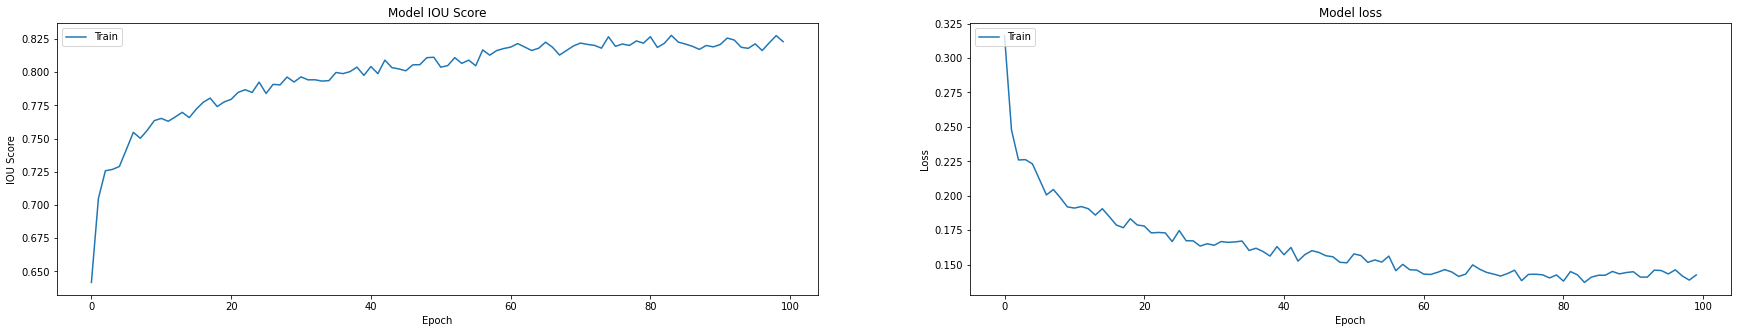

In [17]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
# plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### 2) Train model last backbone block unfreezed and rest freezed only on train data

<p>Set backbone trainable to True (but only block4) and rest of the model to False.</p>

In [ ]:
for layer in base_model.layers:
    if ("block4" in layer.name):
        layer.trainable = True

for layer in model.layers:
    if "functional" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

    print(layer.name + ": " + str(layer.trainable))

up_sampling2d: False
functional_1: True
convolution_bn_activation: False
convolution_bn_activation_1: False
pam__module: False
cam__module: False
convolution_bn_activation_5: False
convolution_bn_activation_6: False
dropout: False
dropout_1: False
dropout_2: False
convolution_bn_activation_7: False
convolution_bn_activation_8: False
convolution_bn_activation_9: False
concatenate_1: False
concatenate_2: False
convolution_bn_activation_10: False


In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
            #  tf.keras.callbacks.ModelCheckpoint("DeepLabV3plus.ckpt", verbose=1, save_weights_only=True, save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

In [ ]:
history = model.fit(
    TrainSet,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    callbacks=callbacks,
    )

Epoch 1/100
152/152 [==============================] - 94s 619ms/step - loss: 0.2110 - iou_score: 0.7372
Epoch 2/100
152/152 [==============================] - 95s 622ms/step - loss: 0.2146 - iou_score: 0.7302
Epoch 3/100
152/152 [==============================] - 95s 624ms/step - loss: 0.2047 - iou_score: 0.7435
Epoch 4/100
152/152 [==============================] - 94s 619ms/step - loss: 0.2030 - iou_score: 0.7451
Epoch 5/100
152/152 [==============================] - 95s 623ms/step - loss: 0.2015 - iou_score: 0.7460
Epoch 6/100
152/152 [==============================] - 95s 623ms/step - loss: 0.1976 - iou_score: 0.7507
Epoch 7/100
152/152 [==============================] - 94s 621ms/step - loss: 0.2022 - iou_score: 0.7443
Epoch 8/100
152/152 [==============================] - 94s 619ms/step - loss: 0.2028 - iou_score: 0.7455
Epoch 9/100
152/152 [==============================] - 94s 621ms/step - loss: 0.1924 - iou_score: 0.7570
Epoch 10/100
152/152 [==============================] -

KeyboardInterrupt: ignored

### Plot Training IoU Scores and Losses

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
# plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### 3) Train completly unfreezed model with train and test data

<p>Make whole model trainable and use validation set.</p>

In [18]:
for layer in model.layers:
    layer.trainable = True

    print(layer.name + ": " + str(layer.trainable))

up_sampling2d: True
functional_1: True
convolution_bn_activation: True
convolution_bn_activation_1: True
pam__module: True
cam__module: True
convolution_bn_activation_5: True
convolution_bn_activation_6: True
dropout: True
dropout_1: True
dropout_2: True
convolution_bn_activation_7: True
convolution_bn_activation_8: True
convolution_bn_activation_9: True
concatenate_1: True
concatenate_2: True
convolution_bn_activation_10: True


In [19]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
            #  tf.keras.callbacks.ModelCheckpoint("DeepLabV3plus.ckpt", verbose=1, save_weights_only=True, save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

In [20]:
history = model.fit(
    TrainSetwwoAug,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    callbacks=callbacks,
    validation_data=ValidationSet,
    validation_steps=len(os.listdir(x_valid_dir)),
    )

Epoch 1/100
152/152 [==============================] - 195s 1s/step - loss: 0.1686 - iou_score: 0.7906 - val_loss: 0.1631 - val_iou_score: 0.7931
Epoch 2/100
152/152 [==============================] - 69s 453ms/step - loss: 0.1555 - iou_score: 0.8047 - val_loss: 0.1353 - val_iou_score: 0.8319
Epoch 3/100
152/152 [==============================] - 69s 452ms/step - loss: 0.1492 - iou_score: 0.8120 - val_loss: 0.1269 - val_iou_score: 0.8372
Epoch 4/100
152/152 [==============================] - 69s 451ms/step - loss: 0.1425 - iou_score: 0.8212 - val_loss: 0.1378 - val_iou_score: 0.8250
Epoch 5/100
152/152 [==============================] - 68s 450ms/step - loss: 0.1503 - iou_score: 0.8119 - val_loss: 0.1331 - val_iou_score: 0.8280
Epoch 6/100
152/152 [==============================] - 69s 454ms/step - loss: 0.1453 - iou_score: 0.8196 - val_loss: 0.1289 - val_iou_score: 0.8335
Epoch 7/100
152/152 [==============================] - 68s 450ms/step - loss: 0.1444 - iou_score: 0.8199 - val_los

### Plot Training IoU Scores and Losses

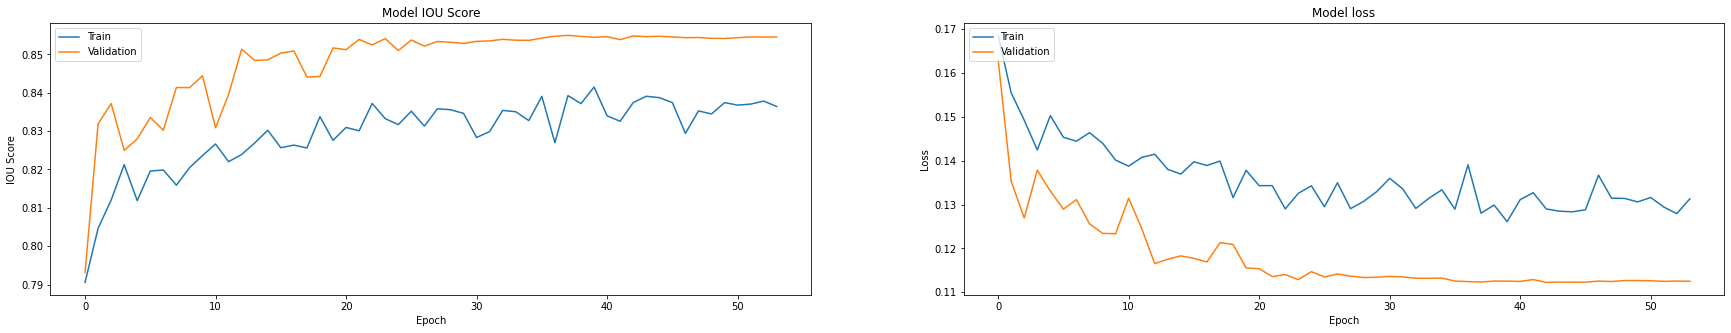

In [21]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluation on Test Data

In [22]:
scores = model.evaluate(TestSet, steps=101)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    if metric != "accuracy":
        metric = metric.__name__
    print("mean {}: {:.5}".format(metric, value))

101/101 [==============================] - 243s 2s/step - loss: 0.1033 - iou_score: 0.8625
Loss: 0.10327
mean iou_score: 0.86253


## Visual Examples on Test Data

[84 79 27 51 61]
27


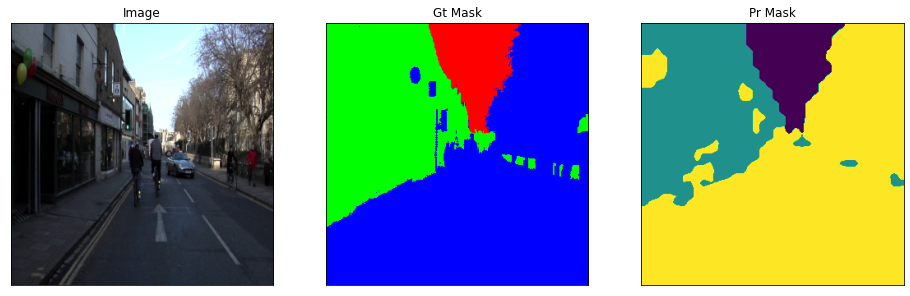

51


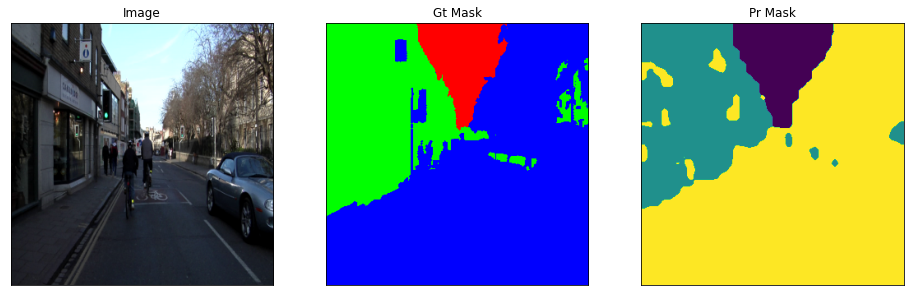

61


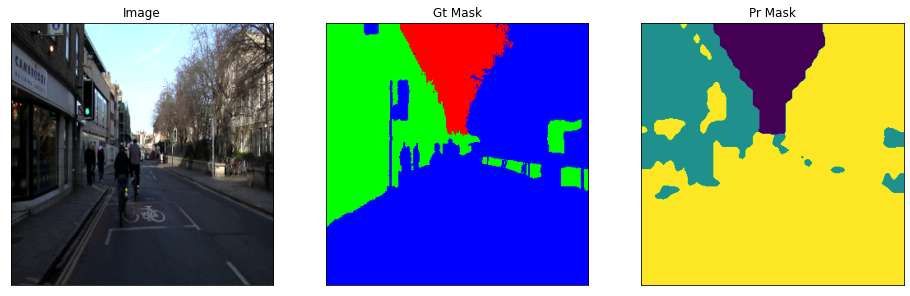

79


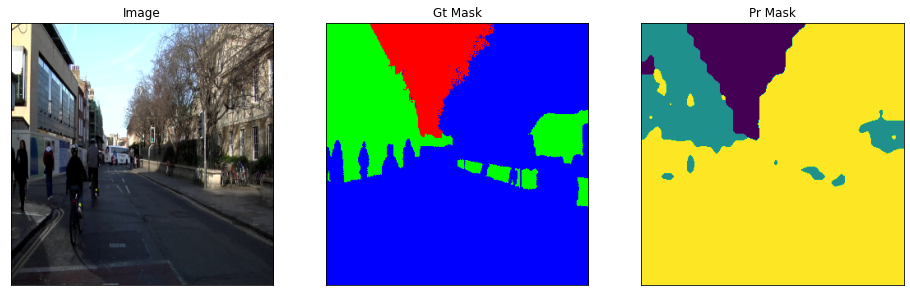

84


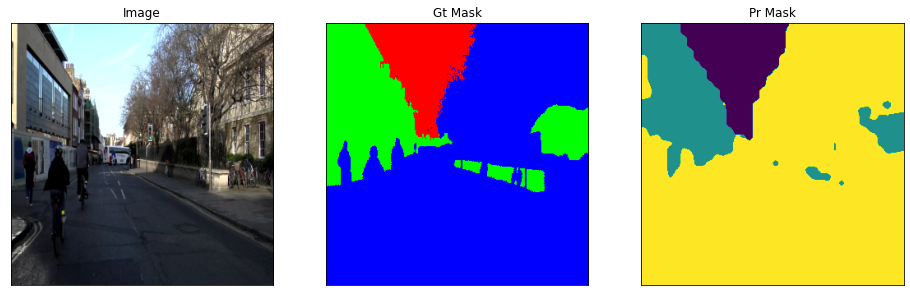

In [24]:
n = 5
ids = np.random.choice(np.arange(101), size=n,replace=False)
print(ids)

counter = 0
second_counter = 0
for i in TestSet:
    if counter in ids:
        image, gt_mask = i
        # image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image)
        pr_mask = np.argmax(pr_mask, axis=-1)

        print(counter)
        
        visualize(
            image=denormalize(image.numpy().squeeze()),
            gt_mask=gt_mask.numpy().squeeze(),
            pr_mask=pr_mask.squeeze(),
        )
        second_counter += 1
    counter += 1
    if second_counter == n:
        break